## Convert GLIMS polygons to RGI polygons: Level 1 files

GLIMS outlines are shared in a format where each polygon is either a glacier outline or a rock outcrop (nunatak). RGI outlines are provided as polygons with exterior (glacier outlines) and interior (outcrops) boundaries. GLIMS does offer download in either format, but it is buggy and [silently fails on some glaciers](https://github.com/GLIMS-RGI/glims_issue_tracker/issues/2).

Therefore, this script is there to convert the GLIMS format to RGI format. L1 files are simply the same data as L0 but with the new format. Additionally, we kept a list of "orphaned" outcrops which hint at errors in either the GLIMS database or this script.

In [103]:
from oggm import utils
import geopandas as gpd
import pandas as pd
import numpy as np
import shutil
import glob
import os
import subprocess
import tarfile
import shapely.geometry as shpg
import progressbar
import warnings

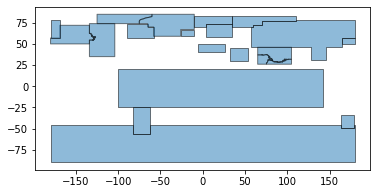

In [2]:
reg_file = 'zip://../l0_regions/00_rgi70_regions.zip/00_rgi70_regions/00_rgi70_O1Regions.shp'
reg_f = gpd.read_file(reg_file)

In [3]:
# We drop the second alaska box which is useless
reg_f = reg_f.drop(1)

In [149]:
odir = utils.mkdir('../l1_with_interiors')
odir_tar = utils.mkdir('../l1_with_interiors_tars')

odir_failed = utils.mkdir('../l1_orphan_interiors')
odir_failed_tar = utils.mkdir('../l1_orphan_interiors_tars')

for reg in range(1, 20):
    
    # Read the shapes for one or more boxes
    shp = [] 
    for i, sreg in reg_f.loc[reg_f.RGI_CODE == f'{reg:02d}'].iterrows():
        
        filebasename = f'../l0_from_glims/{i:02d}_RGI{reg:02d}.tgz'
        print(filebasename)
        with tarfile.open(filebasename, "r:gz") as tar:
            fn = tar.getnames()[0]
        fp = 'tar://' + filebasename + '/{}/glims_polygons.shp'.format(fn)
        shp.append(gpd.read_file(fp))
    
    # Merge them together
    shp = pd.concat(shp)    
    
    # Compute areas
    shp['area'] = shp.to_crs({'proj':'cea'}).area
    
    # Now the interior things
    
    # We group per anlys_id which is the smalles unit of glacier in GLIMS 
    # (a single GLIMSID can have several dates and/or contributor, for example)
    grouped = shp.groupby('anlys_id')
    
    # We loop over anlys_id
    odf = []
    odf_rocks = []
    for name, group in progressbar.progressbar(grouped):

        # Basic sanity checks
        assert len(group.glac_id.unique()) == 1
        assert len(group.anlys_time.unique()) == 1
        assert len(group.src_date.unique()) == 1
        assert len(group.release_dt.unique()) == 1
        assert len(group.submitters.unique()) == 1
        assert len(group.analysts.unique()) == 1

        # Select the various (1 - more) main rocks
        mains = group.loc[group.line_type == 'glac_bound'].copy()

        # And all rocks
        rocks = group.loc[group.line_type == 'intrnl_rock']

        # We sort areas to avoid misclassifications
        mains = mains.sort_values('area')

        # Now loop over the mains and check which rocks belong
        for i, main in mains.iterrows():

            try:
                # Check where the rocks belong
                isin = rocks.geometry.within(main.geometry)
            except:
                # An error occurred
                # The ids below have been manually checked - that's not many in light of the thousands of entries
                if main.glac_id in ['G282321E08973S', 'G286431E47184S', 'G293140E68314S', 
                                    'G294835E68160S', 'G295727E65746S']:
                    mains = mains.drop(i)
                    isin = []
                elif main.glac_id in ['G286765E46650S']:
                    main['geometry'] = main.geometry.buffer(0)[1]
                    isin = rocks.geometry.within(main.geometry)
                elif main.glac_id in ['G282313E08974S', 'G286697E46659S', 'G286765E46650S', 
                                      'G292617E67510S', 'G294132E67719S', 'G012723E47107N']:
                    rocks = rocks[rocks.is_valid]
                    isin = rocks.geometry.within(main.geometry)
                else:
                    raise
            exterior = main.geometry.exterior
            interiors = [p.exterior for p in rocks.loc[isin].geometry]
            if len(interiors) > 0:
                mains.loc[i, 'geometry'] = shpg.Polygon(exterior, interiors)
                rocks = rocks[~isin]

        odf.append(mains)
        odf_rocks.append(rocks)

    odf = pd.concat(odf)
    odf_rocks = pd.concat(odf_rocks)
    
    dd = utils.mkdir(f'{odir}/RGI{reg:02d}/', reset=True)
    print('Writing...')
    odf.to_file(dd + f'RGI{reg:02d}.shp')
    
    print('Taring...')
    print(subprocess.run(['tar', '-zcvf', f'{odir_tar}/RGI{reg:02d}.tar.gz', '-C', odir, f'RGI{reg:02d}']))
    
    if len(odf_rocks) > 0:
        dd = utils.mkdir(f'{odir_failed}/RGI{reg:02d}/', reset=True)
        print('Writing orphans...')
        odf_rocks.to_file(dd + f'RGI{reg:02d}.shp')

        print('Taring orphans...')
        print(subprocess.run(['tar', '-zcvf', f'{odir_failed_tar}/RGI{reg:02d}.tar.gz', '-C', odir_failed, f'RGI{reg:02d}']))

../l0_from_glims/00_RGI01.tgz


100% (50387 of 50387) |##################| Elapsed Time: 0:04:56 Time:  0:04:56


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI01.tar.gz', '-C', '../l1_with_interiors', 'RGI01'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI01.tar.gz', '-C', '../l1_orphan_interiors', 'RGI01'], returncode=0)
../l0_from_glims/02_RGI02.tgz


100% (33741 of 33741) |##################| Elapsed Time: 0:02:53 Time:  0:02:53


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI02.tar.gz', '-C', '../l1_with_interiors', 'RGI02'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI02.tar.gz', '-C', '../l1_orphan_interiors', 'RGI02'], returncode=0)
../l0_from_glims/03_RGI03.tgz


100% (11555 of 11555) |##################| Elapsed Time: 0:00:59 Time:  0:00:59


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI03.tar.gz', '-C', '../l1_with_interiors', 'RGI03'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI03.tar.gz', '-C', '../l1_orphan_interiors', 'RGI03'], returncode=0)
../l0_from_glims/04_RGI04.tgz


100% (7816 of 7816) |####################| Elapsed Time: 0:00:39 Time:  0:00:39


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI04.tar.gz', '-C', '../l1_with_interiors', 'RGI04'], returncode=0)
../l0_from_glims/05_RGI05.tgz


100% (32900 of 32900) |##################| Elapsed Time: 0:03:24 Time:  0:03:24


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI05.tar.gz', '-C', '../l1_with_interiors', 'RGI05'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI05.tar.gz', '-C', '../l1_orphan_interiors', 'RGI05'], returncode=0)
../l0_from_glims/06_RGI06.tgz


100% (584 of 584) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI06.tar.gz', '-C', '../l1_with_interiors', 'RGI06'], returncode=0)
../l0_from_glims/07_RGI07.tgz


100% (5214 of 5214) |####################| Elapsed Time: 0:00:27 Time:  0:00:27


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI07.tar.gz', '-C', '../l1_with_interiors', 'RGI07'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI07.tar.gz', '-C', '../l1_orphan_interiors', 'RGI07'], returncode=0)
../l0_from_glims/08_RGI08.tgz


100% (3547 of 3547) |####################| Elapsed Time: 0:00:16 Time:  0:00:16


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI08.tar.gz', '-C', '../l1_with_interiors', 'RGI08'], returncode=0)
../l0_from_glims/09_RGI09.tgz


100% (3815 of 3815) |####################| Elapsed Time: 0:00:22 Time:  0:00:22


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI09.tar.gz', '-C', '../l1_with_interiors', 'RGI09'], returncode=0)
../l0_from_glims/10_RGI10.tgz
../l0_from_glims/11_RGI10.tgz


100% (314136 of 314136) |################| Elapsed Time: 0:24:15 Time:  0:24:15


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI10.tar.gz', '-C', '../l1_with_interiors', 'RGI10'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI10.tar.gz', '-C', '../l1_orphan_interiors', 'RGI10'], returncode=0)
../l0_from_glims/12_RGI11.tgz


 37% (10990 of 28957) |######            | Elapsed Time: 0:00:54 ETA:   0:01:26TopologyException: side location conflict at 12.726751999999999 47.110363999999997 0
100% (28957 of 28957) |##################| Elapsed Time: 0:02:26 Time:  0:02:26


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI11.tar.gz', '-C', '../l1_with_interiors', 'RGI11'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI11.tar.gz', '-C', '../l1_orphan_interiors', 'RGI11'], returncode=0)
../l0_from_glims/13_RGI12.tgz


100% (8404 of 8404) |####################| Elapsed Time: 0:00:40 Time:  0:00:40


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI12.tar.gz', '-C', '../l1_with_interiors', 'RGI12'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI12.tar.gz', '-C', '../l1_orphan_interiors', 'RGI12'], returncode=0)
../l0_from_glims/15_RGI14.tgz


100% (188060 of 188060) |################| Elapsed Time: 0:14:52 Time:  0:14:52


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI14.tar.gz', '-C', '../l1_with_interiors', 'RGI14'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI14.tar.gz', '-C', '../l1_orphan_interiors', 'RGI14'], returncode=0)
../l0_from_glims/16_RGI15.tgz


100% (125400 of 125400) |################| Elapsed Time: 0:09:38 Time:  0:09:38


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI15.tar.gz', '-C', '../l1_with_interiors', 'RGI15'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI15.tar.gz', '-C', '../l1_orphan_interiors', 'RGI15'], returncode=0)
../l0_from_glims/17_RGI16.tgz


 15% (781 of 5203) |###                  | Elapsed Time: 0:00:05 ETA:   0:00:32TopologyException: side location conflict at -77.680957000000006 -8.9723860000000002 0
TopologyException: side location conflict at -77.685458999999994 -8.9728949999999994 0
100% (5203 of 5203) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI16.tar.gz', '-C', '../l1_with_interiors', 'RGI16'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI16.tar.gz', '-C', '../l1_orphan_interiors', 'RGI16'], returncode=0)
../l0_from_glims/18_RGI17.tgz


N/A% (0 of 50724) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--TopologyException: side location conflict at -73.256309999999999 -46.701590000000003 0
  1% (577 of 50724) |                    | Elapsed Time: 0:00:04 ETA:   0:06:34TopologyException: side location conflict at -73.209220999999999 -46.658822999999998 0
100% (50724 of 50724) |##################| Elapsed Time: 0:04:33 Time:  0:04:33


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI17.tar.gz', '-C', '../l1_with_interiors', 'RGI17'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI17.tar.gz', '-C', '../l1_orphan_interiors', 'RGI17'], returncode=0)
../l0_from_glims/19_RGI18.tgz


100% (3853 of 3853) |####################| Elapsed Time: 0:00:17 Time:  0:00:17


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI18.tar.gz', '-C', '../l1_with_interiors', 'RGI18'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI18.tar.gz', '-C', '../l1_orphan_interiors', 'RGI18'], returncode=0)
../l0_from_glims/20_RGI19.tgz


  0% (4 of 38316) |                      | Elapsed Time: 0:00:00 ETA:   0:16:27TopologyException: side location conflict at -73.256309999999999 -46.701590000000003 0
  4% (1603 of 38316) |                   | Elapsed Time: 0:00:12 ETA:   0:04:54TopologyException: side location conflict at -73.209220999999999 -46.658822999999998 0
100% (38316 of 38316) |##################| Elapsed Time: 0:04:21 Time:  0:04:21


Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l1_with_interiors_tars/RGI19.tar.gz', '-C', '../l1_with_interiors', 'RGI19'], returncode=0)
Writing orphans...
Taring orphans...
CompletedProcess(args=['tar', '-zcvf', '../l1_orphan_interiors_tars/RGI19.tar.gz', '-C', '../l1_orphan_interiors', 'RGI19'], returncode=0)
